## Libraries

In [156]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from sklearn import set_config; set_config(display='diagram')
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer, make_column_selector,ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_validate
from functools import reduce


## Load Data 

In [157]:
df_22 = pd.read_csv('../raw_data/fifa22/players_22.csv')
df_21 = pd.read_csv('../raw_data/fifa22/players_21.csv')
df_20 = pd.read_csv('../raw_data/fifa22/players_20.csv')
df_19 = pd.read_csv('../raw_data/fifa22/players_19.csv')
df_18 = pd.read_csv('../raw_data/fifa22/players_18.csv')
df_17 = pd.read_csv('../raw_data/fifa22/players_17.csv')
df_16 = pd.read_csv('../raw_data/fifa22/players_16.csv')
df_15 = pd.read_csv('../raw_data/fifa22/players_15.csv')

/var/folders/tc/0tkkgmdd25n0rh3_pjfhw6mw0000gp/T/ipykernel_58079/3992483976.py:1: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_22 = pd.read_csv('../raw_data/fifa22/players_22.csv')
/var/folders/tc/0tkkgmdd25n0rh3_pjfhw6mw0000gp/T/ipykernel_58079/3992483976.py:5: DtypeWarning: Columns (81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_18 = pd.read_csv('../raw_data/fifa22/players_18.csv')
/var/folders/tc/0tkkgmdd25n0rh3_pjfhw6mw0000gp/T/ipykernel_58079/3992483976.py:7: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  df_16 = pd.read_csv('../raw_data/fifa22/players_16.csv')
/var/folders/tc/0tkkgmdd25n0rh3_pjfhw6mw0000gp/T/ipykernel_58079/3992483976.py:8: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  df_15 = pd.read_csv('../raw_data/fifa22/players_15.csv')


In [158]:
for index, col in enumerate(df_22.columns):
    print(f"{col:<26} | ", end="")
    if (index % 3 == 2):
        print("\n", end="")

sofifa_id                  | player_url                 | short_name                 | 
long_name                  | player_positions           | overall                    | 
potential                  | value_eur                  | wage_eur                   | 
age                        | dob                        | height_cm                  | 
weight_kg                  | club_team_id               | club_name                  | 
league_name                | league_level               | club_position              | 
club_jersey_number         | club_loaned_from           | club_joined                | 
club_contract_valid_until  | nationality_id             | nationality_name           | 
nation_team_id             | nation_position            | nation_jersey_number       | 
preferred_foot             | weak_foot                  | skill_moves                | 
international_reputation   | work_rate                  | body_type                  | 
real_face                  | rel

In [159]:
to_drop = ['club_logo_url','nation_flag_url','club_flag_url','nation_logo_url','player_face_url','dob','player_url',
           'real_face','nation_jersey_number','nation_position','club_loaned_from','long_name','player_url'
          ,'ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm',
           'rm','lwb','ldm', 'cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk','club_jersey_number','nationality_id','club_jersey_number',
          'goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking' ,'goalkeeping_positioning' ,'goalkeeping_reflexes', 'goalkeeping_speed']



In [160]:
df22 = df_22.drop(to_drop, axis = 1)
df21 = df_21.drop(to_drop, axis = 1)
df20 = df_20.drop(to_drop, axis = 1)
df19 = df_19.drop(to_drop, axis = 1)
df18 = df_18.drop(to_drop, axis = 1)
df17 = df_17.drop(to_drop, axis = 1)
df16 = df_16.drop(to_drop, axis = 1)
df15 = df_15.drop(to_drop, axis = 1)

## Feature engineering

### Starter Line Up 

In [161]:
def is_bench(d):
    if d in ("SUB", "RES", ""):
        return True 
    return False

### Age bins

In [162]:
def age_bins(a):
    if a <= 19:
        return 'Below 20'
    if 20 <= a <= 24:
        return '20-24'
    if 25 <= a <= 29:
        return '25-29'
    if 30 <= a <= 34:
        return '30-34'
    if a >= 35:
        return 'Over 34'

### Top Nationality 

In [163]:
def top_nationality(val):
    top_nat = list(df22.nationality_name.value_counts().iloc[:20].index)
    if val not in top_nat:
        return 'Others'
    return val

### Player Positions

In [164]:
def play_pos(a):
    if a in ('ST','CF','RF','LF','RW','LW'):
        return 'ATT'
    if a in ('RM','LM','CAM','CDM','CM','LWB','RWB'):
        return 'MID'
    if a in ('CB','CF','LB','RB'):
        return 'DEF'
    return a

In [165]:
pos22 = df22['player_positions']
pos21 = df21['player_positions']
pos20 = df20['player_positions']
pos19 = df19['player_positions']
pos18 = df18['player_positions']
pos17 = df17['player_positions']
pos16 = df16['player_positions']
pos15 = df15['player_positions']


pref_pos_22 = []
pref_pos_21 = []
pref_pos_20 = []
pref_pos_19 = []
pref_pos_18 = []
pref_pos_17 = []
pref_pos_16 = []
pref_pos_15 = []

In [166]:
pos = [pos18, pos19, pos20, pos21,pos22,pos17,pos16,pos15]

for i in pos22:
    a = i.split(',')
    pref_pos_22.append(a[0])
df22['prefered_pos'] = pref_pos_22

for i in pos21:
    a = i.split(',')
    pref_pos_21.append(a[0])
df21['prefered_pos'] = pref_pos_21


for i in pos20:
    a = i.split(',')
    pref_pos_20.append(a[0])
df20['prefered_pos'] = pref_pos_20

for i in pos19:
    a = i.split(',')
    pref_pos_19.append(a[0])
df19['prefered_pos'] = pref_pos_19

for i in pos18:
    a = i.split(',')
    pref_pos_18.append(a[0])
df18['prefered_pos'] = pref_pos_18

for i in pos17:
    a = i.split(',')
    pref_pos_17.append(a[0])
df17['prefered_pos'] = pref_pos_17

for i in pos16:
    a = i.split(',')
    pref_pos_16.append(a[0])
df16['prefered_pos'] = pref_pos_16

for i in pos15:
    a = i.split(',')
    pref_pos_15.append(a[0])
df15['prefered_pos'] = pref_pos_15  



In [167]:
df22 = df22.drop('player_positions', axis = 1)
df21 = df21.drop('player_positions', axis = 1)
df20 = df20.drop('player_positions', axis = 1)
df19 = df19.drop('player_positions', axis = 1)
df18 = df18.drop('player_positions', axis = 1)
df17 = df17.drop('player_positions', axis = 1)
df16 = df16.drop('player_positions', axis = 1)
df15 = df15.drop('player_positions', axis = 1)

df22['prefered_pos'] = df22['prefered_pos'].astype('category')
df21['prefered_pos'] = df21['prefered_pos'].astype('category')
df20['prefered_pos'] = df20['prefered_pos'].astype('category')
df19['prefered_pos'] = df19['prefered_pos'].astype('category')
df18['prefered_pos'] = df18['prefered_pos'].astype('category')
df17['prefered_pos'] = df17['prefered_pos'].astype('category')
df16['prefered_pos'] = df16['prefered_pos'].astype('category')
df15['prefered_pos'] = df15['prefered_pos'].astype('category')




### all together

In [168]:
dfs = [df22, df19, df20, df21]

for frame in dfs:
    frame['is_bench'] = frame['club_position'].apply(is_bench)
    frame['potential_diff'] = frame['potential'] - frame['overall']
    frame[['att_rate', 'def_rate']] = frame['work_rate'].str.split('/', 1, expand=True)
    frame['age_bin'] = frame['age'].apply(age_bins)
    frame['player_pos'] = frame['prefered_pos'].apply(play_pos)
    frame['new_nationality'] = frame['nationality_name'].apply(top_nationality)

## Team Metric Dataframes

### Team Averages

In [169]:
df22_team = df22.groupby(['club_name'])[['value_eur','overall','potential']].mean().reset_index().add_suffix('_mean')
df21_team = df21.groupby(['club_name'])[['value_eur','overall','potential']].mean().reset_index().add_suffix('_mean')
df20_team = df20.groupby(['club_name'])[['value_eur','overall','potential']].mean().reset_index().add_suffix('_mean')
df19_team = df19.groupby(['club_name'])[['value_eur','overall','potential']].mean().reset_index().add_suffix('_mean')

df22_team = df22_team.rename(columns={"club_name_mean": "club_name"})
df21_team = df21_team.rename(columns={"club_name_mean": "club_name"})
df20_team = df20_team.rename(columns={"club_name_mean": "club_name"})
df19_team = df19_team.rename(columns={"club_name_mean": "club_name"})
    

### Team Avg per player positions

In [170]:

df22_team_pos = df22.groupby(['club_name','player_pos'])[['value_eur','overall','potential']].mean().reset_index() \
                .pivot(index='club_name',columns='player_pos',values=['value_eur','overall','potential'])
df21_team_pos = df21.groupby(['club_name','player_pos'])[['value_eur','overall','potential']].mean().reset_index() \
                .pivot(index='club_name',columns='player_pos',values=['value_eur','overall','potential'])
df20_team_pos = df20.groupby(['club_name','player_pos'])[['value_eur','overall','potential']].mean().reset_index() \
                .pivot(index='club_name',columns='player_pos',values=['value_eur','overall','potential'])
df19_team_pos = df19.groupby(['club_name','player_pos'])[['value_eur','overall','potential']].mean().reset_index() \
                .pivot(index='club_name',columns='player_pos',values=['value_eur','overall','potential'])


df22_team_pos.columns = list(map("_".join, df22_team_pos.columns))
df22_team_pos = df22_team_pos.rename(columns={"club_name_": "club_name"}).reset_index()

df21_team_pos.columns = list(map("_".join, df21_team_pos.columns))
df21_team_pos = df21_team_pos.rename(columns={"club_name_": "club_name"}).reset_index()

df20_team_pos.columns = list(map("_".join, df20_team_pos.columns))
df20_team_pos = df20_team_pos.rename(columns={"club_name_": "club_name"}).reset_index()

df19_team_pos.columns = list(map("_".join, df19_team_pos.columns))
df19_team_pos = df19_team_pos.rename(columns={"club_name_": "club_name"}).reset_index()

df22_team_pos

,club_name,value_eur_ATT,value_eur_DEF,value_eur_GK,value_eur_MID,overall_ATT,overall_DEF,overall_GK,overall_MID,potential_ATT,potential_DEF,potential_GK,potential_MID
0,1. FC Heidenheim 1846,1.810000e+06,1.725000e+06,9.000000e+05,1.540909e+06,67.400000,68.000000,66.000000,66.181818,70.600000,72.500000,69.666667,70.909091
1,1. FC Kaiserslautern,7.625000e+05,6.444444e+05,5.600000e+05,8.958333e+05,62.250000,62.333333,59.666667,64.166667,69.750000,67.222222,68.666667,68.166667
2,1. FC Köln,2.850000e+06,2.410000e+06,2.242500e+06,4.215000e+06,73.000000,69.600000,64.500000,69.600000,73.000000,75.900000,72.250000,76.333333
3,1. FC Magdeburg,6.666667e+05,6.275000e+05,4.416667e+05,7.916667e+05,62.666667,62.100000,59.666667,62.555556,66.500000,67.800000,67.666667,67.777778
4,1. FC Nürnberg,1.332143e+06,1.143182e+06,5.783333e+05,1.690625e+06,65.714286,65.636364,66.000000,65.625000,71.714286,70.363636,67.000000,72.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,Örebro SK,6.312500e+05,5.350000e+05,3.300000e+05,6.063636e+05,61.250000,62.142857,58.666667,61.818182,67.250000,65.428571,62.666667,66.000000
697,Östersunds FK,5.166667e+05,5.875000e+05,2.950000e+05,6.013333e+05,61.666667,62.750000,65.500000,60.866667,64.000000,65.750000,66.000000,66.200000
698,İstanbul Başakşehir FK,2.837500e+06,1.860000e+06,6.916667e+05,4.800000e+06,70.250000,69.400000,62.333333,72.800000,73.250000,73.600000,67.666667,74.500000
699,İttifak Holding Konyaspor,1.950000e+06,1.271875e+06,5.833333e+05,1.408333e+06,70.250000,68.625000,66.666667,66.222222,71.000000,69.625000,67.333333,69.666667


### Team Avg per player positions and start members

In [171]:
df22_team_start = df22[df22['is_bench']==False].groupby(['club_name','player_pos'])[['value_eur','overall','potential']].mean().reset_index() \
                .pivot(index='club_name',columns='player_pos',values=['value_eur','overall','potential'])
df21_team_start = df21[df21['is_bench']==False].groupby(['club_name','player_pos'])[['value_eur','overall','potential']].mean().reset_index() \
                .pivot(index='club_name',columns='player_pos',values=['value_eur','overall','potential'])
df20_team_start = df20[df20['is_bench']==False].groupby(['club_name','player_pos'])[['value_eur','overall','potential']].mean().reset_index() \
                .pivot(index='club_name',columns='player_pos',values=['value_eur','overall','potential'])
df19_team_start = df19[df19['is_bench']==False].groupby(['club_name','player_pos'])[['value_eur','overall','potential']].mean().reset_index() \
                .pivot(index='club_name',columns='player_pos',values=['value_eur','overall','potential'])


df22_team_start.columns = list(map("_".join, df22_team_start.columns))
df22_team_start = df22_team_start.rename(columns={"club_name_": "club_name"}).add_suffix('_start').reset_index()

df21_team_start.columns = list(map("_".join, df21_team_start.columns))
df21_team_start = df21_team_start.rename(columns={"club_name_": "club_name"}).add_suffix('_start').reset_index()

df20_team_start.columns = list(map("_".join, df20_team_start.columns))
df20_team_start = df20_team_start.rename(columns={"club_name_": "club_name"}).add_suffix('_start').reset_index()

df19_team_start.columns = list(map("_".join, df19_team_start.columns))
df19_team_start = df19_team_start.rename(columns={"club_name_": "club_name"}).add_suffix('_start').reset_index()

df22_team_start

,club_name,value_eur_ATT_start,value_eur_DEF_start,value_eur_GK_start,value_eur_MID_start,overall_ATT_start,overall_DEF_start,overall_GK_start,overall_MID_start,potential_ATT_start,potential_DEF_start,potential_GK_start,potential_MID_start
0,1. FC Heidenheim 1846,2500000.0,2.400000e+06,1600000.0,2.133333e+06,70.333333,72.250000,72.0,68.000000,72.666667,72.750000,72.0,73.666667
1,1. FC Kaiserslautern,1300000.0,7.687500e+05,450000.0,8.300000e+05,64.000000,63.000000,59.0,65.600000,75.000000,68.750000,68.0,67.000000
2,1. FC Köln,2850000.0,2.166667e+06,6500000.0,7.300000e+06,73.000000,71.000000,76.0,75.200000,73.000000,73.666667,78.0,77.800000
3,1. FC Magdeburg,775000.0,6.437500e+05,575000.0,1.043750e+06,62.500000,64.000000,63.0,64.250000,68.500000,66.500000,68.0,68.750000
4,1. FC Nürnberg,1600000.0,1.506250e+06,1100000.0,2.650000e+06,68.000000,70.000000,70.0,70.250000,75.000000,71.500000,70.0,75.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,Örebro SK,837500.0,5.475000e+05,700000.0,4.450000e+05,65.000000,62.000000,67.0,62.500000,65.000000,65.250000,67.0,66.250000
697,Östersunds FK,650000.0,6.833333e+05,240000.0,6.950000e+05,62.500000,64.333333,69.0,62.000000,66.000000,66.333333,69.0,67.000000
698,İstanbul Başakşehir FK,2400000.0,2.466667e+06,925000.0,5.733333e+06,72.000000,69.333333,71.0,72.333333,72.000000,77.666667,71.0,75.166667
699,İttifak Holding Konyaspor,1800000.0,1.700000e+06,800000.0,1.756250e+06,69.500000,71.000000,70.0,67.250000,71.000000,71.500000,70.0,70.500000


## Join Dataframes

In [119]:
df22_team

,club_name_mean,value_eur_mean,overall_mean,potential_mean
0,1. FC Heidenheim 1846,1.574074e+06,66.925926,71.185185
1,1. FC Kaiserslautern,7.600000e+05,62.821429,68.142857
2,1. FC Köln,3.290161e+06,69.161290,75.451613
3,1. FC Magdeburg,6.687500e+05,62.107143,67.500000
4,1. FC Nürnberg,1.281379e+06,65.689655,70.896552
...,...,...,...,...
696,Örebro SK,5.572000e+05,61.440000,65.640000
697,Östersunds FK,5.629167e+05,61.666667,65.833333
698,İstanbul Başakşehir FK,2.963889e+06,70.000000,73.222222
699,İttifak Holding Konyaspor,1.350000e+06,67.750000,69.583333


In [172]:
data_frames = [df22, df22_team,df22_team_pos, df22_team_start]
df_2022 = reduce(lambda  left,right: pd.merge(left,right,on=['club_name'],how='outer'), data_frames)

data_frames = [df21, df21_team,df21_team_pos, df21_team_start]
df_2021 = reduce(lambda  left,right: pd.merge(left,right,on=['club_name'],how='outer'), data_frames)

data_frames = [df20, df20_team,df20_team_pos, df20_team_start]
df_2020 = reduce(lambda  left,right: pd.merge(left,right,on=['club_name'],how='outer'), data_frames)

data_frames = [df19, df19_team,df19_team_pos, df19_team_start]
df_2019 = reduce(lambda  left,right: pd.merge(left,right,on=['club_name'],how='outer'), data_frames)



In [173]:
list_df = [df19, df19_team,df19_team_pos, df19_team_start]
for i,v in enumerate(list_df):
    print(v.shape)

(18085, 70)
(651, 4)
(651, 13)
(651, 13)


In [174]:
df_all = df_2022.merge(df_2021, how='outer',left_on='sofifa_id', right_on='sofifa_id', suffixes=(None, '_21'))
df_all = df_all.merge(df_2020, how='outer',left_on='sofifa_id', right_on='sofifa_id', suffixes=(None,'_20'))
df_all = df_all.merge(df_2019, how='outer',left_on='sofifa_id', right_on='sofifa_id', suffixes=(None, '_19'))



# df_all = df_all.merge(df18, how='outer',left_on='sofifa_id', right_on='sofifa_id', suffixes=(None, '_18'))
# df_all = df_all.merge(df17, how='outer',left_on='sofifa_id', right_on='sofifa_id', suffixes=(None, '_17'))
# df_all = df_all.merge(df16, how='outer',left_on='sofifa_id', right_on='sofifa_id', suffixes=(None, '_16'))
# df_all = df_all.merge(df15, how='outer',left_on='sofifa_id', right_on='sofifa_id', suffixes=(None, '_15'))

In [175]:
print(df_2022.shape,df22.shape)
print(df_all.shape)

(19239, 97) (19239, 70)
(32727, 385)


In [125]:
for index, col in enumerate(df_all.columns):
    print(f"{col:<26} | ", end="")
    if (index % 3 == 2):
        print("\n", end="")

sofifa_id                  | short_name                 | overall                    | 
potential                  | value_eur                  | wage_eur                   | 
age                        | height_cm                  | weight_kg                  | 
club_team_id               | club_name                  | league_name                | 
league_level               | club_position              | club_joined                | 
club_contract_valid_until  | nationality_name           | nation_team_id             | 
preferred_foot             | weak_foot                  | skill_moves                | 
international_reputation   | work_rate                  | body_type                  | 
release_clause_eur         | player_tags                | player_traits              | 
pace                       | shooting                   | passing                    | 
dribbling                  | defending                  | physic                     | 
attacking_crossing         | att

In [23]:
df_plot=df_all[['sofifa_id','overall_15','overall_16','overall_17','overall_18','overall_19','overall_20','overall_21','overall']]


In [176]:
df_all['is_bench_21'] = df_all['is_bench_21'].astype('bool')
df_all['is_bench_20'] = df_all['is_bench_20'].astype('bool')
df_all['is_bench_19'] = df_all['is_bench_19'].astype('bool')
# df_all['is_bench_18'] = df_all['is_bench_18'].astype('bool')
# df_all['is_bench_17'] = df_all['is_bench_17'].astype('bool')
# df_all['is_bench_16'] = df_all['is_bench_16'].astype('bool')
# df_all['is_bench_15'] = df_all['is_bench_15'].astype('bool')

In [177]:
df_all.select_dtypes("bool").nunique()

is_bench_21    2
is_bench_20    2
is_bench_19    2
dtype: int64

In [178]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32727 entries, 0 to 32726
Columns: 385 entries, sofifa_id to potential_MID_start_19
dtypes: bool(3), category(4), float64(312), int64(1), object(65)
memory usage: 94.9+ MB


In [179]:
# df_all.select_dtypes("float64").nunique()

df_all.work_rate.value_counts()

Medium/Medium    10015
High/Medium       3661
Medium/High       1880
High/High         1099
Medium/Low         810
High/Low           808
Low/Medium         466
Low/High           455
Low/Low             45
Name: work_rate, dtype: int64

In [180]:
feat_categorical_nunique = df_all.select_dtypes("object").nunique()
feat_categorical_nunique

short_name            18145
club_name               701
league_name              55
club_position            29
club_joined            1845
                      ...  
att_rate_19               3
def_rate_19               3
age_bin_19                5
player_pos_19             4
new_nationality_19       21
Length: 65, dtype: int64

In [182]:
feat_categorical_small = feat_categorical_nunique[feat_categorical_nunique < 22]
feat_categorical_small

preferred_foot         2
work_rate              9
body_type             10
is_bench               2
att_rate               3
def_rate               3
age_bin                5
player_pos             4
new_nationality       21
preferred_foot_21      2
work_rate_21           9
body_type_21          10
att_rate_21            3
def_rate_21            3
age_bin_21             5
player_pos_21          4
new_nationality_21    21
preferred_foot_20      2
work_rate_20           9
body_type_20          10
att_rate_20            3
def_rate_20            3
age_bin_20             5
player_pos_20          4
new_nationality_20    21
preferred_foot_19      2
work_rate_19           9
body_type_19          10
att_rate_19            3
def_rate_19            3
age_bin_19             5
player_pos_19          4
new_nationality_19    21
dtype: int64

In [31]:
wk_drop = ['work_rate','work_rate_21','work_rate_20','work_rate_19',
           'work_rate_18','work_rate_17','work_rate_16','work_rate_15']

df_all = df_all.drop(wk_drop, axis = 1)

In [32]:
df_all[['short_name','short_name_20','short_name_15','short_name_16','short_name_17']]

,short_name,short_name_20,short_name_15,short_name_16,short_name_17
0,L. Messi,L. Messi,L. Messi,L. Messi,L. Messi
1,R. Lewandowski,R. Lewandowski,R. Lewandowski,R. Lewandowski,R. Lewandowski
2,Cristiano Ronaldo,Cristiano Ronaldo,Cristiano Ronaldo,Cristiano Ronaldo,Cristiano Ronaldo
3,Neymar Jr,Neymar Jr,Neymar,Neymar,Neymar
4,K. De Bruyne,K. De Bruyne,K. De Bruyne,K. De Bruyne,K. De Bruyne
...,...,...,...,...,...
45624,NaN,NaN,B. Jackson,NaN,NaN
45625,NaN,NaN,M. Fissore,NaN,NaN
45626,NaN,NaN,H. Reynolds,NaN,NaN
45627,NaN,NaN,L. Davies,NaN,NaN


## Pipeline

In [190]:
# Preprocessor

# num_transformer = make_pipeline(SimpleImputer(), MinMaxScaler())

# cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=True)
SimpleImputer.get_feature_names_out = (lambda self, names=None:
                                       self.feature_names_in_)

num_transformer = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
num_col = make_column_selector(dtype_include=['int64','float64'])

cat_transformer = make_pipeline(SimpleImputer(strategy = 'most_frequent')
                                ,OneHotEncoder(handle_unknown='ignore', sparse=True)
                               )

cat_col = make_column_selector(dtype_include=['object','bool','category'])

preproc = make_column_transformer(
    (num_transformer, make_column_selector(dtype_include=['float64','int64'])),
    (cat_transformer, cat_col),
    remainder='passthrough')



# Add Estimator
# pipe = make_pipeline(preproc, Lasso(alpha=0.2))
pipe = make_pipeline(preproc, LinearRegression())
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x125205040>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x121b90190>)])),
                ('linearregression', LinearRegression())])

In [184]:
## Filter df_all to keep overall of 2022 and features of 2021


# 2021 features
# X=df_all.drop(columns='overall')
cols = [col for col in df_all.columns if '_21' in col or 'value_eur' == col]

df = df_all[cols]
new_df = df[df['value_eur'].notnull()&df['short_name_21'].notnull()]
# df_all[cols].isna().sum()

# # new_df = df_all[cols].dropna(axis=0, how='all')
# # X = new_df.drop(columns='overall').dropna(axis=0)
X = new_df.drop(columns='value_eur')
# # cols
# # # X = df_all[cols].dropna(axis=0,how='all')
y = new_df.value_eur
# # # X
# # X

In [185]:
X

,short_name_21,overall_21,potential_21,value_eur_21,wage_eur_21,age_21,height_cm_21,weight_kg_21,club_team_id_21,club_name_21,...,value_eur_GK_start_21,value_eur_MID_start_21,overall_ATT_start_21,overall_DEF_start_21,overall_GK_start_21,overall_MID_start_21,potential_ATT_start_21,potential_DEF_start_21,potential_GK_start_21,potential_MID_start_21
0,L. Messi,93.0,93.0,103500000.0,560000.0,33.0,170.0,72.0,241.0,FC Barcelona,...,110000000.0,6.625000e+07,84.750000,85.000000,90.0,85.000000,89.750000,86.750000,93.0,87.500000
1,Neymar Jr,91.0,91.0,132000000.0,270000.0,28.0,175.0,68.0,73.0,Paris Saint-Germain,...,26000000.0,5.650000e+07,88.250000,79.000000,87.0,85.000000,89.750000,83.750000,87.0,85.500000
2,K. Mbappé,90.0,95.0,185500000.0,160000.0,21.0,178.0,73.0,73.0,Paris Saint-Germain,...,26000000.0,5.650000e+07,88.250000,79.000000,87.0,85.000000,89.750000,83.750000,87.0,85.500000
3,G. Donnarumma,85.0,92.0,93500000.0,34000.0,21.0,196.0,90.0,47.0,AC Milan,...,93500000.0,1.583333e+07,80.333333,79.750000,85.0,77.000000,80.666667,83.250000,92.0,81.333333
4,Sergio Ramos,89.0,89.0,33500000.0,300000.0,34.0,184.0,82.0,243.0,Real Madrid CF,...,82000000.0,7.150000e+07,85.333333,86.000000,89.0,88.000000,89.000000,87.750000,90.0,88.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,A. O'Driscoll,57.0,70.0,375000.0,2000.0,21.0,187.0,65.0,1940.0,Mansfield Town,...,325000.0,8.125000e+05,64.000000,63.500000,63.0,62.750000,64.000000,69.000000,63.0,68.750000
19215,P. Kirk,60.0,69.0,525000.0,500.0,22.0,175.0,66.0,305.0,Bohemian FC,...,300000.0,6.530000e+05,60.000000,59.750000,60.0,60.800000,69.000000,68.250000,65.0,68.800000
19219,D. Williams,53.0,65.0,230000.0,500.0,20.0,174.0,58.0,306.0,Shamrock Rovers,...,90000.0,6.625000e+05,66.500000,62.750000,66.0,63.500000,69.000000,66.750000,66.0,66.250000
19221,C. Davis,55.0,66.0,275000.0,600.0,22.0,165.0,68.0,422.0,Cork City,...,25000.0,3.750000e+05,55.000000,56.000000,60.0,57.800000,66.000000,64.750000,60.0,66.200000


In [186]:
y=np.log(y)

In [187]:
X_train22, X_test22, y_train22, y_test22 = train_test_split(X, y, test_size=0.3,random_state=10)

In [191]:
pipe.fit(X_train22,y_train22)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x125205040>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x121b90190>)])),
                ('linearregression', LinearRegression())])

<BarContainer object of 21 artists>

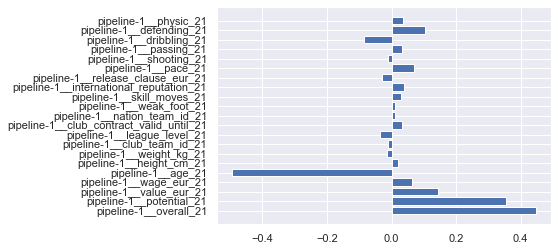

In [192]:
plt.barh(pipe[:-1].get_feature_names_out()[0:21],pipe[-1].coef_[0:21])


In [38]:
(new_df.groupby('age_21','league_level_21')['value_eur'].agg(['var','median']))

ValueError: No axis named league_level_21 for object type DataFrame

In [193]:
len(pipe[:-1].get_feature_names_out())

12190

In [77]:
pipe.predict(X_test22.iloc[0:2])

array([6017343.34231355,  436961.59239022])

In [99]:
# pipe[-1].coef_[pipe[-1].coef_ != 0]
# plt.bar(pipe.feature_names_in_, pipe[-1].coef_)
# pipe.get_feature_names_out()
# pipe[:-1].get_feature_names_out()
# pipe[:-1].get_feature_names_out()
# pipe[:-1].named_steps["columntransformer"].get_feature_names_out()

In [85]:
from sklearn.model_selection import cross_val_score,cross_validate

# pipe.fit(X,y)
# pipe.score(X,y)
# pipe.predict(new_data)
cv_results = cross_validate(pipe, X_train22, y_train22, cv=5, 
                            scoring=['neg_mean_absolute_error','r2']
                           )
pd.DataFrame(cv_results)

,fit_time,score_time,test_neg_mean_absolute_error,test_r2
0,1.281172,0.070041,-2.090403e+06,0.829273
1,1.124896,0.057626,-1.898122e+06,0.821520
2,1.067990,0.062612,-1.938309e+06,0.849740
3,1.102597,0.064257,-2.024564e+06,0.799233
4,1.179876,0.056139,-2.024613e+06,0.830087


In [83]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [79]:
predicted_overall = pipe.predict(X_test22)
predicted_overall

array([ 6017343.34231355,   436961.59239022, -1509714.63370387, ...,
        8686262.77258582, 17415587.63371428,  2775406.71722659])

In [92]:
predictions = {'y_pred' : predicted_overall,
             'y_true': y_test22}

# comparison = pd.dataframe({y_true:[y_test22,pd.Series(predicted_overall,name ='Pred_Overall')],axis = 1)
# comparison

pd.DataFrame(predictions).sort_index()

,y_pred,y_true
4,1.185641e+08,125500000.0
13,6.963623e+07,104000000.0
18,8.087641e+07,94000000.0
19,8.646843e+07,108000000.0
21,7.830170e+07,119500000.0
...,...,...
18917,7.720154e+05,140000.0
19006,1.310512e+06,110000.0
19103,2.524278e+05,120000.0
19117,-3.522981e+05,70000.0


In [93]:
new_df[4:]

,value_eur,short_name_21,overall_21,potential_21,value_eur_21,wage_eur_21,age_21,height_cm_21,weight_kg_21,club_team_id_21,...,mentality_penalties_21,mentality_composure_21,defending_marking_awareness_21,defending_standing_tackle_21,defending_sliding_tackle_21,is_bench_21,potential_diff_21,att_rate_21,def_rate_21,prefered_pos_21
4,125500000.0,K. De Bruyne,91.0,91.0,129000000.0,370000.0,29.0,181.0,70.0,10.0,...,84.0,91.0,68.0,65.0,53.0,False,0.0,High,High,CAM
5,112000000.0,J. Oblak,91.0,93.0,120000000.0,125000.0,27.0,188.0,87.0,240.0,...,11.0,68.0,27.0,12.0,18.0,False,2.0,Medium,Medium,GK
6,194000000.0,K. Mbappé,90.0,95.0,185500000.0,160000.0,21.0,178.0,73.0,73.0,...,70.0,84.0,34.0,34.0,32.0,False,5.0,High,Low,ST
7,13500000.0,M. Neuer,89.0,89.0,17500000.0,130000.0,34.0,193.0,92.0,21.0,...,47.0,70.0,17.0,10.0,11.0,False,0.0,Medium,Medium,GK
8,99000000.0,M. ter Stegen,90.0,93.0,110000000.0,260000.0,28.0,187.0,85.0,241.0,...,25.0,70.0,25.0,13.0,10.0,False,3.0,Medium,Medium,GK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19180,110000.0,Zhang Wei,49.0,57.0,100000.0,1000.0,20.0,186.0,74.0,112978.0,...,36.0,43.0,46.0,52.0,46.0,True,8.0,Medium,Medium,RM
19185,80000.0,P. McGarvey,48.0,58.0,80000.0,500.0,16.0,180.0,76.0,111131.0,...,17.0,38.0,5.0,10.0,13.0,True,10.0,Medium,Medium,GK
19188,70000.0,Guo Yunqi,48.0,53.0,70000.0,1000.0,23.0,175.0,68.0,112985.0,...,41.0,40.0,43.0,48.0,44.0,True,5.0,Low,Low,CM
19220,100000.0,D. Collins,48.0,61.0,110000.0,500.0,19.0,174.0,68.0,563.0,...,40.0,50.0,39.0,29.0,27.0,True,13.0,Medium,Medium,ST


In [90]:
len(predicted_overall)

3975

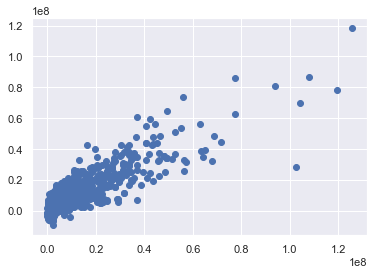

In [99]:
plt.scatter(y_test22,predicted_overall)


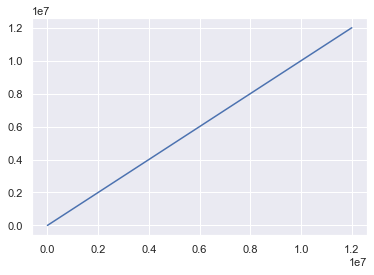

In [102]:
plt.plot(range(0,12000000),range(0,12000000))